My Goal is to understand one of the fundemantals of Machine Learning techniques. 

From my understanding, Auto-regression is based on creating a function f_t(y) with y the variable to be "analysed", in function of time. 

Let's start by importing our dataset

**0. Installing Dependencies**

In [388]:
#Dependencies
%pip install openpyxl matplotlib pandas -q

Note: you may need to restart the kernel to use updated packages.


**1. Retrieving Data**

In [389]:
import pandas as pd
file_path = '../../Data/EnergieUebersichtCH-2024.xlsx' 
xls = pd.ExcelFile(file_path)
#Dataframe in this case in the 3rd sheet Zeitreihen0h15
df = pd.read_excel(xls, sheet_name='Zeitreihen0h15', header=1, nrows=300)
print(df.columns)


Index(['Zeitstempel', 'kWh', 'kWh.1', 'kWh.2', 'kWh.3', 'kWh.4', 'kWh.5',
       'kWh.6', 'kWh.7', 'kWh.8', 'kWh.9', 'kWh.10', 'kWh.11', 'kWh.12',
       'kWh.13', 'kWh.14', 'kWh.15', 'kWh.16', 'kWh.17', 'kWh.18', 'kWh.19',
       'Euro/MWh', 'Euro/MWh.1', 'Euro/MWh.2', 'Euro/MWh.3', 'kWh.20',
       'kWh.21', 'kWh.22', 'kWh.23', 'kWh.24', 'kWh.25', 'kWh.26', 'kWh.27',
       'kWh.28', 'kWh.29', 'kWh.30', 'kWh.31', 'kWh.32', 'kWh.33', 'kWh.34',
       'kWh.35', 'kWh.36', 'kWh.37', 'kWh.38', 'kWh.39', 'kWh.40', 'kWh.41',
       'kWh.42', 'kWh.43', 'kWh.44', 'kWh.45', 'kWh.46', 'kWh.47', 'kWh.48',
       'kWh.49', 'kWh.50', 'kWh.51', 'kWh.52', 'kWh.53', 'kWh.54', 'kWh.55',
       'kWh.56', 'kWh.57', 'kWh.58', 'kWh.59'],
      dtype='object')


**2. Data variables / potential parameters** 

**Pre-processing step** Renaming column names to be clear

In [390]:
column_mapping = {
    'kWh': 'Total Energy Consumed by End Users (kWh)',
    'kWh.1': 'Total Energy Production (kWh)',
    'kWh.2': 'Total Energy Consumption (kWh)',
    'kWh.3': 'Net Outflow (kWh)',
    'kWh.4': 'Grid Feed-In (kWh)',
    'kWh.5': 'Positive Secondary Control Energy (kWh)',
    'kWh.6': 'Negative Secondary Control Energy (kWh)',
    'kWh.7': 'Positive Tertiary Control Energy (kWh)',
    'kWh.8': 'Negative Tertiary Control Energy (kWh)'
}

df.rename(columns=column_mapping, inplace=True)


The goal is to predict the next element of the Total Energy Consumption columb:

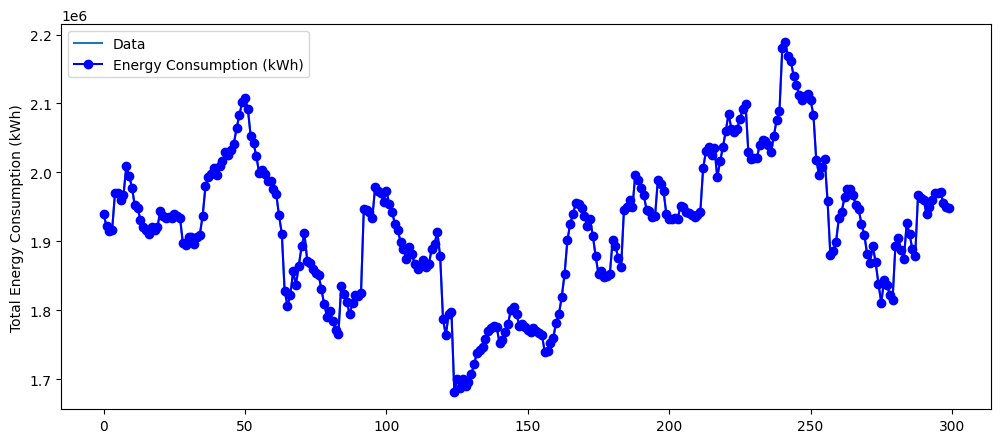

In [391]:
energy_consumption_data = df['Total Energy Consumption (kWh)'].dropna().values 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(energy_consumption_data, label='Data')
plt.plot(energy_consumption_data, label="Energy Consumption (kWh)", color='blue', marker='o')
plt.ylabel("Total Energy Consumption (kWh)")
plt.legend()
plt.show()



Now that we have the data correct set up, let's create two tables: weights, prev_values and the bias

In [392]:
weights = [0 for i in range(100)]
prev_values = [0 for i in range(100)]
y = 100
bias = 0

energy_consumption_data = df['Total Energy Consumption (kWh)'].dropna().values
f_y = df['Total Energy Consumption (kWh)'][y]
print(f_y)


1973067.723669


We have multiple values to affix here, we need to find the weights to approximate our current consumed energy at time t (f(y)). We can use Linear regression to try to find the weights and the bias?

2nd test

In [393]:
import numpy as np
def create_dataset(data, p):
    """
    Converts a time series into input-output pairs for autoregression.
    
    Args:
        data (np.ndarray): The time series data.
        p (int): The order of the autoregressive model.
    
    Returns:
        tuple: (X, y) where X is the input matrix and y is the output vector.
    """
    X, y = [], []
    for i in range(len(data) - p):
        X.append(data[i:i+p])
        y.append(data[i+p])
    return np.array(X), np.array(y)

    """
    Performs gradient descent to optimize coefficients for linear regression.
    
    Parameters:
    X_augmented : numpy.ndarray
        The feature matrix with a bias column.
    y : numpy.ndarray
        The target values.
    coefficients : numpy.ndarray
        Initial coefficients for the model.
    learning_rate : float
        The learning rate for gradient descent.
    num_iter : int
        The number of iterations to perform.
    
    Returns:
    coefficients : numpy.ndarray
        Optimized coefficients.
    cost_history : list
        List of cost function values over iterations.
    """


In [394]:
def gradient_descent(X_augmented, y, coefficients, learning_rate, num_iter):
    m = len(y)
    cost_history = []
    
    
    for _ in range(num_iter):
        # Predictions
        predictions = X_augmented.dot(coefficients)
        error = predictions - y
        gradient = (X_augmented.T.dot(error)) * (2 / m)
        coefficients -= learning_rate * gradient
        # Compute cost
        cost = np.mean(error**2)
        cost_history.append(cost)
    
    return coefficients, cost_history


In [395]:

def ar_gradient_descent(data, p, learning_rate=0.001, num_iter=1000):
    """
    Fits an AR(p) model using gradient descent.
    
    Args:
        data (np.ndarray): The time series data.
        p (int): The order of the autoregressive model.
        learning_rate (float): Learning rate for gradient descent.
        num_iter (int): Number of iterations for gradient descent.
    
    Returns:
        np.ndarray: Model coefficients (intercept followed by AR coefficients).
    """
    X, y = create_dataset(data, p)
    m = X.shape[0]  
    
    # Add a column of ones to X pour le point d'interception (du début)
    X_augmented = np.hstack([np.ones((m, 1)), X])
    cost_history = []
    coefficients = np.zeros(p + 1)

    coefficients,cost_history = gradient_descent(X_augmented, y, coefficients, learning_rate, num_iter)
            
    return coefficients, cost_history

In [396]:
energy_consumption_data = df['Total Energy Consumption (kWh)'].dropna().values
p = 10
cost_history=[]
coefficients, cost_history = ar_gradient_descent(energy_consumption_data, p, learning_rate=0.01, num_iter=1000)
last_p_observations = energy_consumption_data[-p:]  
next_prediction = coefficients[0] + np.dot(last_p_observations, coefficients[1:])
print(f"Predicted next value: {next_prediction}")

Predicted next value: nan


/var/folders/t4/tvh60p3s6t1g30sq60618qpw0000gn/T/ipykernel_36294/909310157.py:13: RuntimeWarning: overflow encountered in square
  cost = np.mean(error**2)
/var/folders/t4/tvh60p3s6t1g30sq60618qpw0000gn/T/ipykernel_36294/909310157.py:11: RuntimeWarning: invalid value encountered in subtract
  coefficients -= learning_rate * gradient


Je cracke et je demande à DeepSeek-R1:32B (Version DuckDuckGo Privée)

In [397]:
    # Normalize data
data_mean = np.mean(energy_consumption_data)
data_std = np.std(energy_consumption_data)
data_normalized = (energy_consumption_data - data_mean) / data_std

In [398]:
p = 100
cost_history=[]
coefficients, cost_history = ar_gradient_descent(data_normalized, p, learning_rate=0.01, num_iter=1000)
last_p_observations = energy_consumption_data[-p:] 
next_prediction = coefficients[0] + np.dot(last_p_observations, coefficients[1:])
print(f"Predicted next value: {next_prediction}")

Predicted next value: 1333525.762386394


Plotting the coefficient

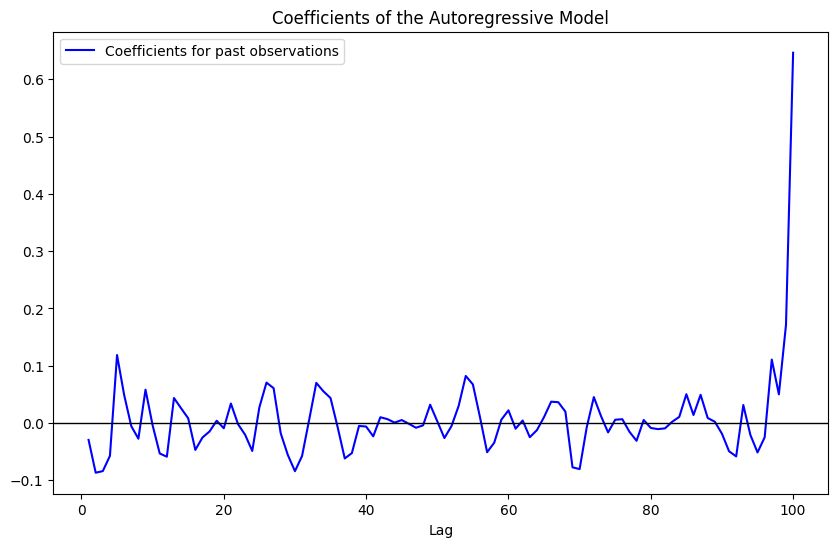

In [399]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, p + 1), coefficients[1:], label='Coefficients for past observations', color='blue')
plt.axhline(0, color='black',linewidth=1) 
plt.xlabel('Lag')
plt.title('Coefficients of the Autoregressive Model')
plt.legend()
plt.show()

Plotting Predictions

In [400]:
y_predictions = np.zeros_like(data_normalized) 
for i in range(p, len(data_normalized)):
    y_predictions[i] = coefficients[0] + np.dot(data_normalized[i-p:i], coefficients[1:])

print(y_predictions[-100:])


[ 0.11754667  0.06566896  0.02169844 -0.02042286  0.06590931  0.26441114
  0.23671965  0.06983485  0.03886156  0.22365776  0.38600978  0.41891618
  0.42871011  0.99549444  1.2968298   1.16195126  0.88071796  1.08347283
  1.03319815  1.15168149  1.14696054  1.26439184  1.46977189  1.4641231
  1.4134002   1.45930143  1.59443999  1.67337335  1.66825948  1.24471914
  1.13410023  1.17052544  1.13718972  1.23052524  1.29811776  1.26882419
  1.18563299  1.19482775  1.41242716  1.63305717  1.79726633  2.41648898
  2.57482139  2.39935261  2.27148695  2.10639352  1.97334657  1.84555901
  1.73871649  1.62462762  1.49076334  1.38356216  1.2753181   0.91872141
  0.83606676  0.9113433   0.9097902   0.39538907 -0.15021252 -0.10333418
  0.00781714  0.11543165  0.28191979  0.44925801  0.56662177  0.49455408
  0.47918778  0.37821587  0.31130582 -0.04083107 -0.26018606 -0.46585424
 -0.50197468 -0.46459707 -0.64810209 -0.87028655 -0.90855192 -0.82734789
 -0.86402069 -0.86655987 -0.66628816 -0.27035487 -0.

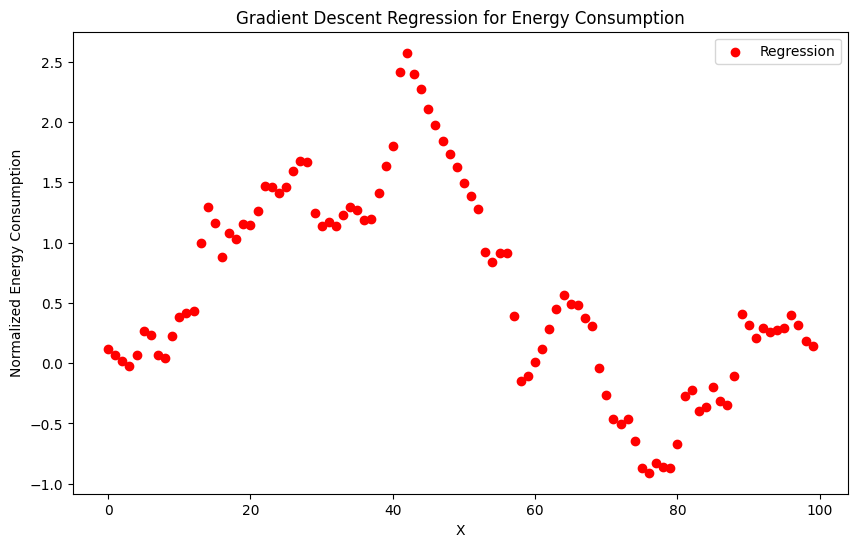

In [401]:
plt.figure(figsize=(10, 6))
X = np.arange(len(y_predictions[-100:]))  # X values for plotting
plt.scatter(X, y_predictions[-100:], color='red', label='Regression')
plt.xlabel('X')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()

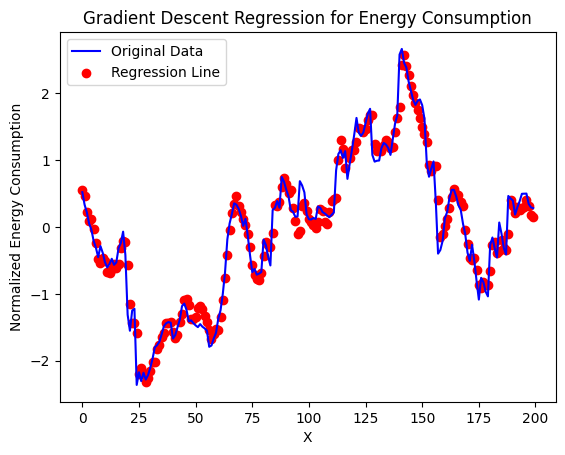

In [402]:
# Plotting
X = np.arange(len(data_normalized[0:200]))  # X values for plotting

# Plot original data and regression line
plt.plot(X, data_normalized[100:300], color='blue', label='Original Data')
plt.scatter(X, y_predictions[100:300], color='red', label='Regression Line')
plt.xlabel('X')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()


Tester avec petit lag, grand lag, petit learning rate, grand learning rate, petit iteration, grand iteration

petit lag: 2

In [403]:
    # Normalize data
data_mean = np.mean(energy_consumption_data)
data_std = np.std(energy_consumption_data)
data_normalized = (energy_consumption_data - data_mean) / data_std


In [404]:
p = 7
cost_history=[]
coefficients, cost_history = ar_gradient_descent(data_normalized, p, learning_rate=0.01, num_iter=1000)
last_p_observations = energy_consumption_data[-p:] 
next_prediction = coefficients[0] + np.dot(last_p_observations, coefficients[1:])
print(f"Predicted next value: {next_prediction}")

Predicted next value: 1852624.1848678144


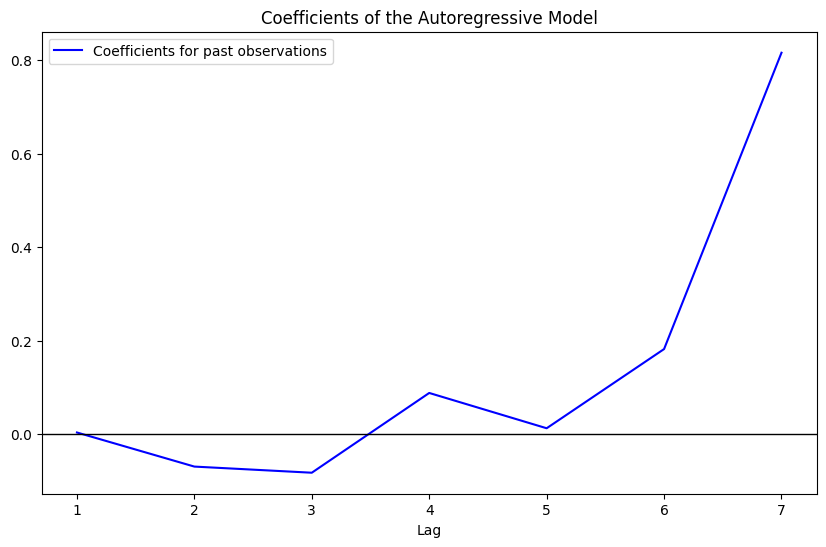

In [405]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, p + 1), coefficients[1:], label='Coefficients for past observations', color='blue')
plt.axhline(0, color='black',linewidth=1) 
plt.xlabel('Lag')
plt.title('Coefficients of the Autoregressive Model')
plt.legend()
plt.show()

Plotting Predictions

In [406]:
y_predictions = np.zeros_like(data_normalized) 
for i in range(p, len(data_normalized)):
    y_predictions[i] = coefficients[0] + np.dot(data_normalized[i-p:i], coefficients[1:])

print(y_predictions[-100:])


[ 0.28833737  0.11947751  0.06038451  0.06245107  0.08271675  0.26118244
  0.2847406   0.22833004  0.21500808  0.16910568  0.12550231  0.15317876
  0.19256859  0.71460319  1.03632287  1.13691804  1.10607483  1.13673577
  0.75699952  0.83727799  1.05829329  1.24716106  1.54210546  1.43912343
  1.34848714  1.36700344  1.434263    1.57595728  1.6870783   1.15021427
  0.94153996  0.91008496  0.83785896  1.03292767  1.18780751  1.18761437
  1.1573176   1.05521744  1.203866    1.42672668  1.57435555  2.37296098
  2.61646404  2.44981807  2.40976542  2.14932091  1.90853874  1.77742087
  1.69270186  1.73612282  1.77639086  1.72413146  1.56168723  0.9973611
  0.68578826  0.72364264  0.797872    0.3768647  -0.29267475 -0.38504569
 -0.34609216 -0.0706448   0.18021891  0.42853296  0.58222991  0.57865755
  0.4870977   0.34943369  0.24622968  0.04639516 -0.12430113 -0.36864647
 -0.52480831 -0.34694799 -0.49697593 -0.76310731 -0.99683555 -0.81958081
 -0.83928671 -0.94506792 -0.95818193 -0.35773524 -0.

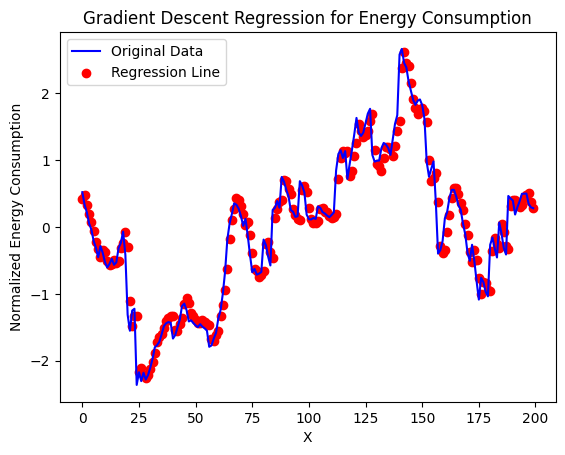

In [407]:
# Plotting
X = np.arange(len(data_normalized[0:200]))  # X values for plotting

# Plot original data and regression line
plt.plot(X, data_normalized[100:300], color='blue', label='Original Data')
plt.scatter(X, y_predictions[100:300], color='red', label='Regression Line')
plt.xlabel('X')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()


p = 50

In [408]:
p = 50
cost_history=[]
coefficients, cost_history = ar_gradient_descent(data_normalized, p, learning_rate=0.01, num_iter=1000)
last_p_observations = energy_consumption_data[-p:] 
next_prediction = coefficients[0] + np.dot(last_p_observations, coefficients[1:])
print(f"Predicted next value: {next_prediction}")

Predicted next value: 1848188.4088882413


Plotting the coefficient

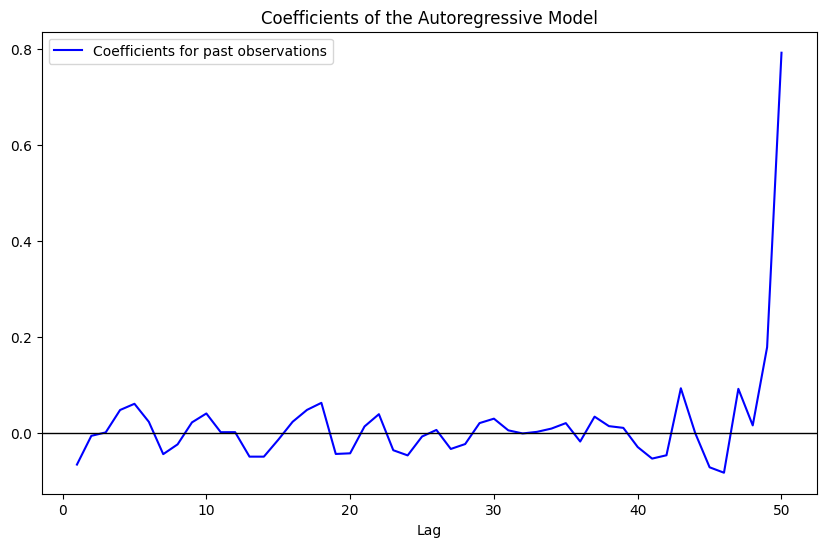

In [409]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, p + 1), coefficients[1:], label='Coefficients for past observations', color='blue')
plt.axhline(0, color='black',linewidth=1) 
plt.xlabel('Lag')
plt.title('Coefficients of the Autoregressive Model')
plt.legend()
plt.show()

In [410]:
y_predictions = np.zeros_like(data_normalized) 
for i in range(p, len(data_normalized)):
    y_predictions[i] = coefficients[0] + np.dot(data_normalized[i-p:i], coefficients[1:])

print(y_predictions[-100:])


[ 0.25314442  0.12995288  0.07386825  0.01389653  0.05636966  0.28342214
  0.33817707  0.2082492   0.15405108  0.20099485  0.22652589  0.20812814
  0.21566845  0.78242636  1.10028068  1.11587469  0.98134755  1.05965613
  0.75866591  0.84357016  1.04951271  1.22065362  1.4422078   1.28870747
  1.18250811  1.24296154  1.42369775  1.58006292  1.62576116  1.16553412
  0.98934856  0.98595731  0.90913922  1.11166672  1.23816697  1.25342453
  1.12049694  1.08512038  1.23539364  1.42358581  1.5276593   2.3315169
  2.59292389  2.44508183  2.34841521  2.13070501  1.89546359  1.76970085
  1.73650767  1.72267426  1.62223816  1.53994353  1.39725014  0.92501814
  0.73036382  0.79930094  0.84833077  0.3975761  -0.26049101 -0.27657882
 -0.20668356  0.08257593  0.31014749  0.47039207  0.46029416  0.43345672
  0.47811252  0.44990947  0.32824196  0.03809101 -0.19586864 -0.46577704
 -0.58162116 -0.37708118 -0.52595621 -0.81480264 -1.06553852 -0.96815989
 -1.00765784 -1.03554164 -0.92319472 -0.32809665 -0.

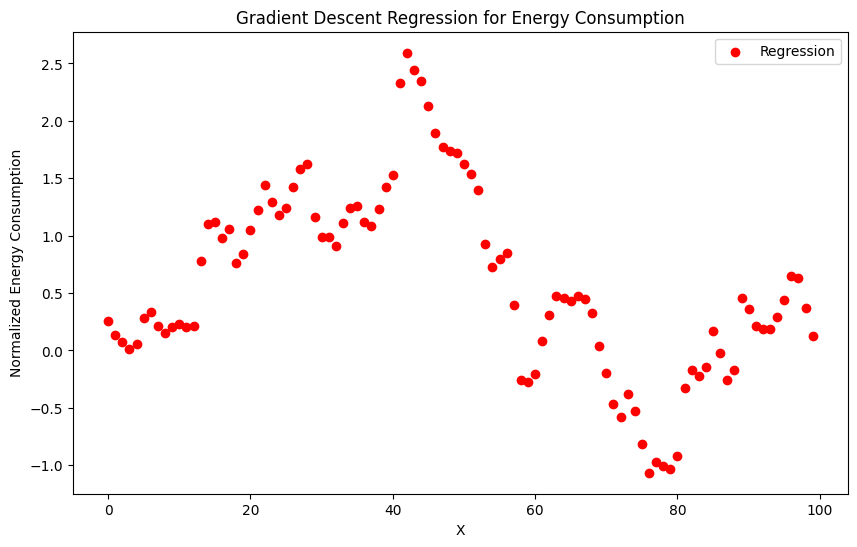

In [411]:
plt.figure(figsize=(10, 6))
X = np.arange(len(y_predictions[-100:]))  # X values for plotting
plt.scatter(X, y_predictions[-100:], color='red', label='Regression')
plt.xlabel('X')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()

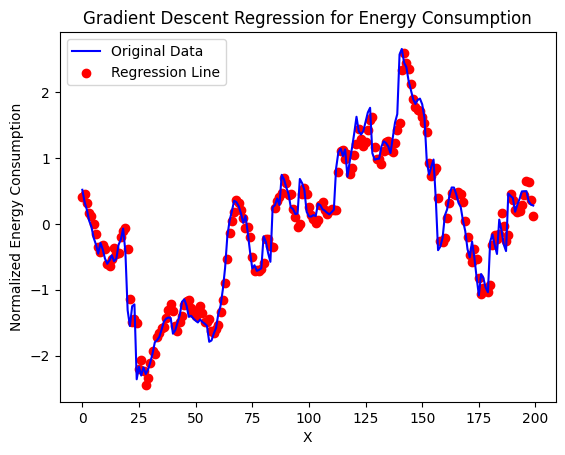

In [412]:
# Plotting
X = np.arange(len(data_normalized[0:200]))  # X values for plotting

# Plot original data and regression line
plt.plot(X, data_normalized[100:300], color='blue', label='Original Data')
plt.scatter(X, y_predictions[100:300], color='red', label='Regression Line')
plt.xlabel('X')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()


p = 7, learning rate = 0.001, iterations sans changement

In [413]:
p = 7
cost_history=[]
coefficients, cost_history = ar_gradient_descent(data_normalized, p, learning_rate=0.001, num_iter=1000)
last_p_observations = energy_consumption_data[-p:] 
next_prediction = coefficients[0] + np.dot(last_p_observations, coefficients[1:])
print(f"Predicted next value: {next_prediction}")

Predicted next value: 1818844.1910848243


Plotting the coefficient

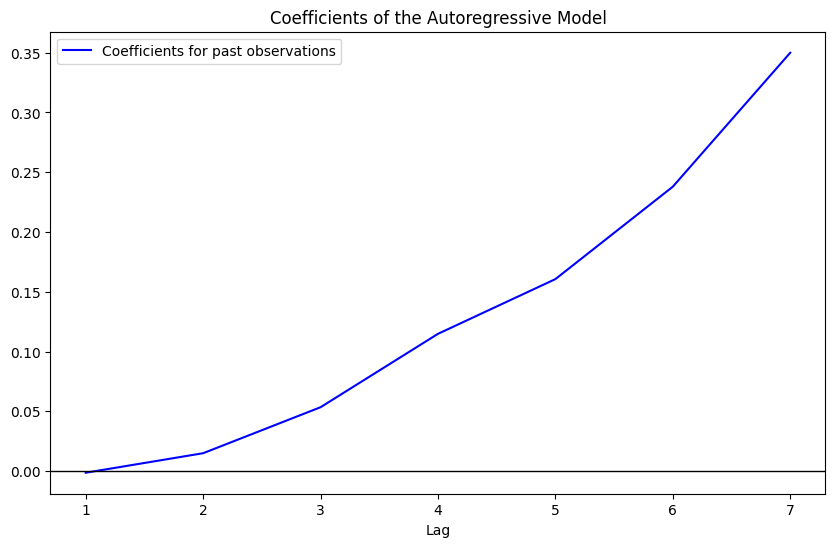

In [414]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, p + 1), coefficients[1:], label='Coefficients for past observations', color='blue')
plt.axhline(0, color='black',linewidth=1) 
plt.xlabel('Lag')
plt.title('Coefficients of the Autoregressive Model')
plt.legend()
plt.show()

In [415]:
y_predictions = np.zeros_like(data_normalized) 
for i in range(p, len(data_normalized)):
    y_predictions[i] = coefficients[0] + np.dot(data_normalized[i-p:i], coefficients[1:])

print(y_predictions[-100:])


[ 3.74846597e-01  2.75684688e-01  1.97458133e-01  1.47992093e-01
  1.20481127e-01  1.77089947e-01  2.14099727e-01  2.16694926e-01
  2.11837157e-01  1.93197504e-01  1.67988198e-01  1.62288442e-01
  1.73499313e-01  4.02915309e-01  6.46079410e-01  8.30638673e-01
  9.17650165e-01  9.97339197e-01  8.87126623e-01  8.76486061e-01
  9.42417237e-01  1.06344227e+00  1.24381289e+00  1.29206774e+00
  1.30396296e+00  1.31800947e+00  1.36204367e+00  1.43999483e+00
  1.52137517e+00  1.33876350e+00  1.17618382e+00  1.06424789e+00
  9.79195015e-01  9.99271511e-01  1.05679409e+00  1.09675296e+00
  1.10728186e+00  1.07404535e+00  1.12669846e+00  1.24019547e+00
  1.36273493e+00  1.76818598e+00  2.07144160e+00  2.19525469e+00
  2.24895882e+00  2.18598849e+00  2.07033355e+00  1.93683177e+00
  1.82520752e+00  1.77905773e+00  1.76254342e+00  1.72932409e+00
  1.64145509e+00  1.35742447e+00  1.08688053e+00  9.45375785e-01
  8.90702804e-01  6.63214781e-01  2.58717299e-01  1.29058532e-02
 -1.12872864e-01 -7.35047

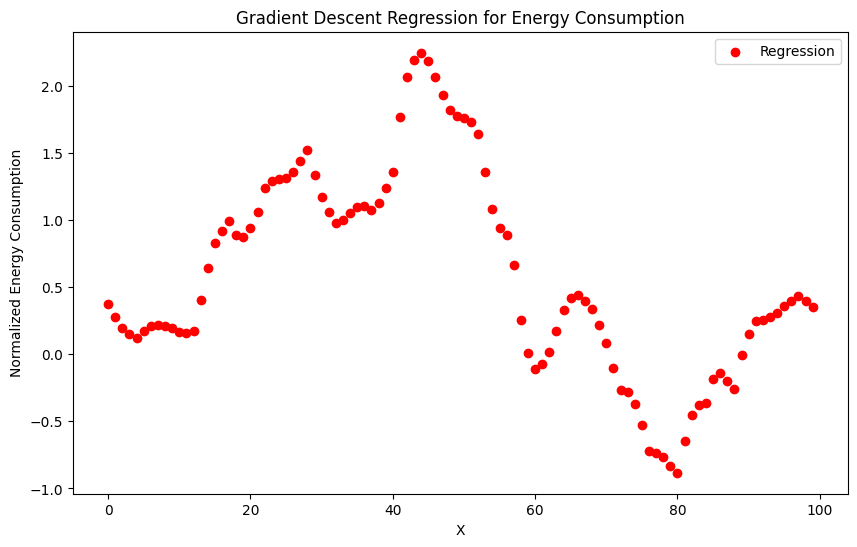

In [416]:
plt.figure(figsize=(10, 6))
X = np.arange(len(y_predictions[-100:]))  # X values for plotting
plt.scatter(X, y_predictions[-100:], color='red', label='Regression')
plt.xlabel('X')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()

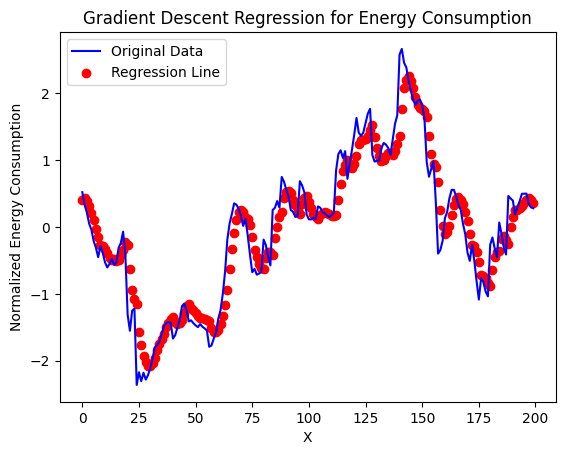

In [417]:
# Plotting
X = np.arange(len(data_normalized[0:200]))  # X values for plotting

# Plot original data and regression line
plt.plot(X, data_normalized[100:300], color='blue', label='Original Data')
plt.scatter(X, y_predictions[100:300], color='red', label='Regression Line')
plt.xlabel('X')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()


p = 7, learning rate 0.01, 100 iterations

In [ ]:
p = 7
cost_history=[]
coefficients, cost_history = ar_gradient_descent(data_normalized, p, learning_rate=0.01, num_iter=100)
last_p_observations = energy_consumption_data[-p:] 
next_prediction = coefficients[0] + np.dot(last_p_observations, coefficients[1:])
print(f"Predicted next value: {next_prediction}")

Predicted next value: 1021302.6072505035


Plotting the coefficient

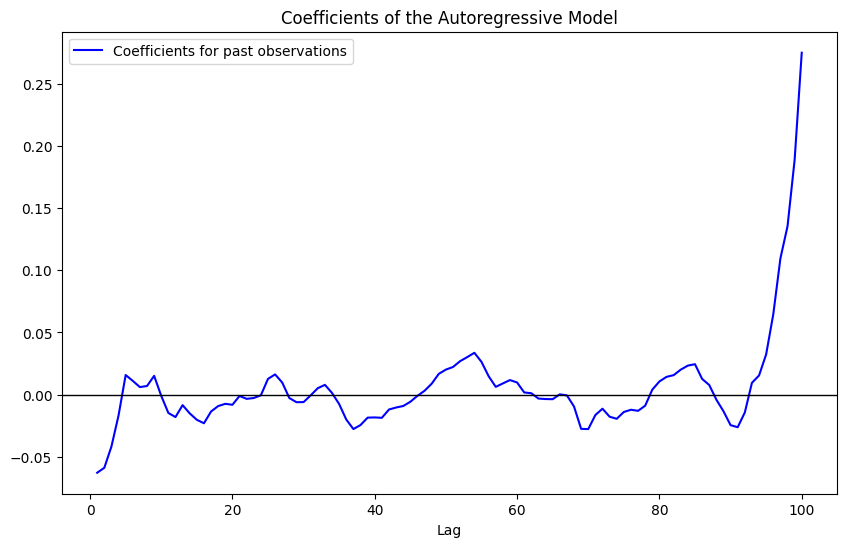

In [419]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, p + 1), coefficients[1:], label='Coefficients for past observations', color='blue')
plt.axhline(0, color='black',linewidth=1) 
plt.xlabel('Lag')
plt.title('Coefficients of the Autoregressive Model')
plt.legend()
plt.show()

In [420]:
y_predictions = np.zeros_like(data_normalized) 
for i in range(p, len(data_normalized)):
    y_predictions[i] = coefficients[0] + np.dot(data_normalized[i-p:i], coefficients[1:])

print(y_predictions[-100:])


[-0.00518105 -0.01472938 -0.01406823  0.00241579  0.04923486  0.17022722
  0.251018    0.28438098  0.32419645  0.41227353  0.49337564  0.54348486
  0.57665768  0.79792269  1.00775283  1.10520546  1.10449421  1.17859415
  1.14645042  1.19144188  1.23742833  1.28403598  1.3726238   1.39991376
  1.41499351  1.39053915  1.42744226  1.48222779  1.54068693  1.39595614
  1.28316222  1.21847412  1.17341698  1.21347939  1.27926704  1.32695975
  1.35261351  1.37544269  1.47614684  1.61011174  1.72331103  2.01488828
  2.20319971  2.24125053  2.22127616  2.14107562  2.02896972  1.8803163
  1.70741929  1.55833449  1.42999695  1.31974983  1.21302411  1.00941408
  0.86664707  0.83802784  0.86166212  0.70489104  0.41618624  0.26746778
  0.19668528  0.21490687  0.25418094  0.32902875  0.40037368  0.43131019
  0.43315869  0.39263186  0.33421091  0.18167101  0.01218306 -0.18784328
 -0.36025455 -0.42487115 -0.54063787 -0.69423488 -0.84972473 -0.87975697
 -0.91394958 -0.93551753 -0.91046729 -0.66931891 -0.

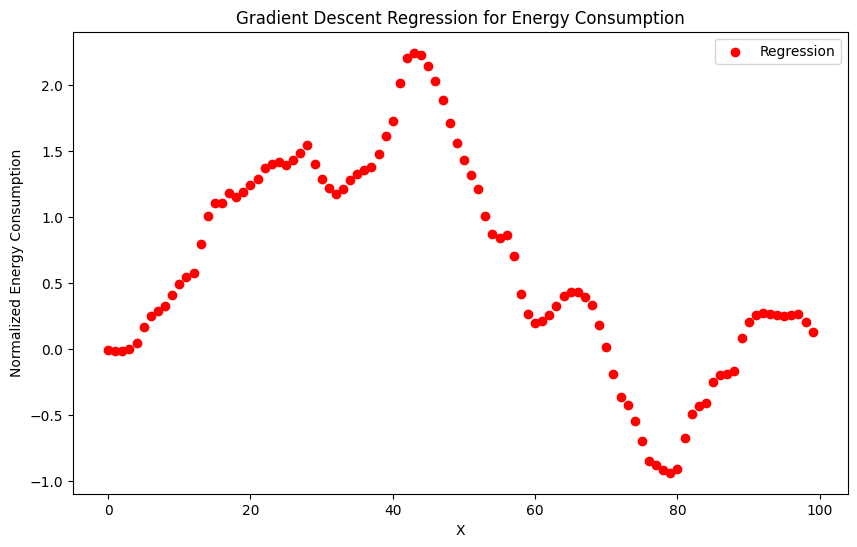

In [421]:
plt.figure(figsize=(10, 6))
X = np.arange(len(y_predictions[-100:]))  # X values for plotting
plt.scatter(X, y_predictions[-100:], color='red', label='Regression')
plt.xlabel('X')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()

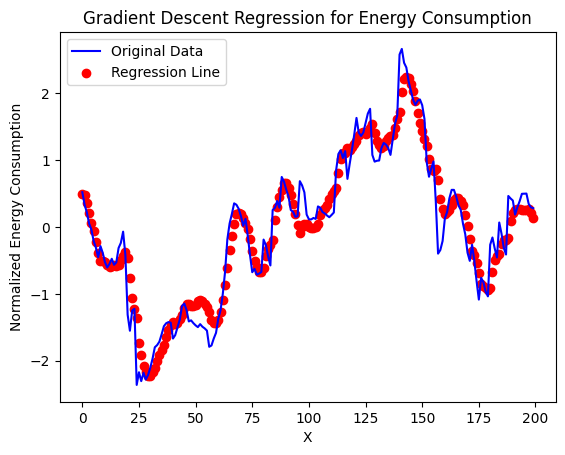

In [422]:
# Plotting
X = np.arange(len(data_normalized[0:200]))  # X values for plotting

# Plot original data and regression line
plt.plot(X, data_normalized[100:300], color='blue', label='Original Data')
plt.scatter(X, y_predictions[100:300], color='red', label='Regression Line')
plt.xlabel('X')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.title('Gradient Descent Regression for Energy Consumption')
plt.show()
